In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !cd /content/drive/MyDrive/BioID-FaceDatabase-V1.2

In [13]:
!pip uninstall scipy -y
!pip install scipy --upgrade --no-cache-dir

Found existing installation: scipy 1.15.3
Uninstalling scipy-1.15.3:
  Successfully uninstalled scipy-1.15.3
ERROR: Operation cancelled by user
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 113.6 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade jax jaxlib

  Using cached jax-0.6.0-py3-none-any.whl.metadata (22 kB)
  Using cached jaxlib-0.6.0-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.2 kB)
Using cached jax-0.6.0-py3-none-any.whl (2.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 MB 6.8 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.30
    Uninstalling jaxlib-0.4.30:
      Successfully uninstalled jaxlib-0.4.30
  Attempting uninstall: jax
    Found existing installation: jax 0.4.30
    Uninstalling jax-0.4.30:
      Successfully uninstalled jax-0.4.30


In [3]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 18.5 MB/s eta 0:00:0000:0100:01


In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

ModuleNotFoundError: No module named 'torch'

In [ ]:
base_path = "/content/drive/MyDrive/BioID-FaceDatabase-V1.2"
image_files = sorted([f for f in os.listdir(base_path) if f.endswith(".pgm")])
label_files = sorted([f for f in os.listdir(base_path) if f.endswith(".eye")])

In [ ]:
data = []
for img_file, label_file in zip(image_files, label_files):
    img_path = os.path.join(base_path, img_file)
    label_path = os.path.join(base_path, label_file)

    with open(label_path, "r") as f:
        lines = f.readlines()
        if len(lines) < 2:
            continue
        lx, ly, rx, ry = map(float, lines[1].strip().split())
        # print(f"left: {lx}, {ly} / right: {rx}, {ry}")
        data.append((img_path, [lx, ly, rx, ry]))


In [ ]:
random.seed(42)
random.shuffle(data)

holdout_data = data[:21]    # 비교용
remaining_data = data[21:]  # 학습용

df = pd.DataFrame(remaining_data, columns=["image_path", "eye_coords"])
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

holdout_df = pd.DataFrame(holdout_data, columns=["image_path", "eye_coords"])

print(len(remaining_data))

1500


In [ ]:
import shutil

output_dir = "/content/drive/MyDrive/comparisons"
if os.path.exists(output_dir) == False:
  os.makedirs(output_dir, exist_ok=True)

  for img_path in holdout_df["image_path"]:
      base_name = os.path.basename(img_path)
      eye_name = base_name.replace(".pgm", ".eye")
      eye_path = os.path.join(os.path.dirname(img_path), eye_name)

      dst_img_path = os.path.join(output_dir, base_name)
      dst_eye_path = os.path.join(output_dir, eye_name)

      shutil.copy(img_path, dst_img_path)

      if os.path.exists(eye_path):
          shutil.copy(eye_path, dst_eye_path)

In [ ]:
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = image.astype(np.float32) / 255.0
    image = np.expand_dims(image, axis=0)  # (1, H, W)
    return image  # (1, 286, 384)

In [ ]:
class EyeDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = preprocess_image(row["image_path"])  # (1, 128, 128)
        label = np.array(row["eye_coords"], dtype=np.float32)
        return torch.tensor(image), torch.tensor(label)

In [ ]:
class HoldoutDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = preprocess_image(row["image_path"])  # (1, H, W)
        label = np.array(row["eye_coords"], dtype=np.float32)
        return torch.tensor(image), torch.tensor(label)

In [ ]:
# class EyeCNN(nn.Module):
#     def __init__(self):
#         super(EyeCNN, self).__init__()
#         self.model = nn.Sequential(
#             nn.Conv2d(1, 32, 3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),   # (1, 286, 384) → (32, 143, 192)

#             nn.Conv2d(32, 64, 3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),  # (64, 71, 96)

#             nn.Conv2d(64, 128, 3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2), # (128, 35, 48)

#             nn.Flatten(),
#             nn.Linear(128 * 35 * 48, 256), nn.ReLU(),
#             nn.Linear(256, 4)  # [lx, ly, rx, ry]
#         )

#     def forward(self, x):
#         return self.model(x)

In [ ]:
class EyeCNN(nn.Module):
    def __init__(self):
        super(EyeCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (286, 384) → (143, 192)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (143, 192) → (71, 96)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (71, 96) → (35, 48)

            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(128 * 35 * 48, 256),
            nn.ReLU(),
            nn.Linear(256, 4)  # [lx, ly, rx, ry]
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
train_dataset = EyeDataset(train_df)
test_dataset = EyeDataset(test_df)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

model = EyeCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
epochs = 250
best_loss = float('inf')
best_model_state = None

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        preds = model(images)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model_state = model.state_dict()


model.load_state_dict(best_model_state)

Epoch [1/250] - Loss: 1704.1063
Epoch [2/250] - Loss: 180.5923
Epoch [3/250] - Loss: 104.4107
Epoch [4/250] - Loss: 91.8760
Epoch [5/250] - Loss: 78.1383
Epoch [6/250] - Loss: 91.9616
Epoch [7/250] - Loss: 59.3211
Epoch [8/250] - Loss: 49.0747
Epoch [9/250] - Loss: 35.9081
Epoch [10/250] - Loss: 38.5549
Epoch [11/250] - Loss: 42.8623
Epoch [12/250] - Loss: 34.1766
Epoch [13/250] - Loss: 39.0533
Epoch [14/250] - Loss: 30.5234
Epoch [15/250] - Loss: 29.9999
Epoch [16/250] - Loss: 34.9154
Epoch [17/250] - Loss: 42.4652
Epoch [18/250] - Loss: 33.6924
Epoch [19/250] - Loss: 29.9662
Epoch [20/250] - Loss: 20.7906
Epoch [21/250] - Loss: 24.1652
Epoch [22/250] - Loss: 30.7498
Epoch [23/250] - Loss: 23.7771
Epoch [24/250] - Loss: 30.8315
Epoch [25/250] - Loss: 43.6667
Epoch [26/250] - Loss: 37.6812
Epoch [27/250] - Loss: 24.6425
Epoch [28/250] - Loss: 24.6411
Epoch [29/250] - Loss: 19.6930
Epoch [30/250] - Loss: 25.5446
Epoch [31/250] - Loss: 28.3934
Epoch [32/250] - Loss: 15.3905
Epoch [33/250

<All keys matched successfully>

In [ ]:
print(best_loss)

4.04826704765621


In [ ]:
def predict(model, dataset, device):
    model.eval()
    predictions = []

    for i in range(len(dataset)):
        image_tensor, _ = dataset[i]
        image_input = image_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            pred = model(image_input).cpu().numpy()[0]
        predictions.append(pred.tolist())

    return predictions

In [ ]:
def print_cnn_predictions(dataset, predictions, num_samples=21):
    data_pairs = []

    for i in range(min(num_samples, len(dataset))):
        _, label = dataset[i]
        pred = predictions[i]

        gt = label.numpy().tolist()
        pr = np.round(pred, 2).tolist()

        print(f"샘플 {i+1}:")
        print(f" - 정답 좌표 (GT):     {label.numpy().tolist()}")
        print(f" - 예측 좌표 (CNN):    {np.round(pred, 2).tolist()}")
        print()

        data_pairs.append((gt, pr))

    mae_list, mse_list, euclidean_list = [], [], []

    for gt, pr in data_pairs:
        gt = np.array(gt)
        pr = np.array(pr)
        diff = gt - pr

        mae = np.mean(np.abs(diff))
        mse = np.mean(diff ** 2)
        euclidean = np.linalg.norm(diff)

        mae_list.append(mae)
        mse_list.append(mse)
        euclidean_list.append(euclidean)

    print(f"📊 MAE (평균 절대 오차): {np.mean(mae_list):.2f}")
    print(f"📊 MSE (평균 제곱 오차): {np.mean(mse_list):.2f}")
    print(f"📊 유클리디안 거리 평균: {np.mean(euclidean_list):.2f}")

In [ ]:
def visualize_predictions(dataset, predictions, num_samples=21, cols=3):
    rows = (num_samples + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

    for i in range(min(num_samples, len(dataset))):
        img_tensor, label = dataset[i]
        img = img_tensor.numpy()[0]
        img = np.squeeze(img)
        pred = predictions[i]

        ax = axes[i // cols][i % cols] if rows > 1 else axes[i]
        ax.imshow(img, cmap='gray')
        ax.scatter(label[0], label[1], color='blue', label='GT Left')
        ax.scatter(label[2], label[3], color='blue', label='GT Right')
        ax.scatter(pred[0], pred[1], color='red', marker='x', label='Pred Left')
        ax.scatter(pred[2], pred[3], color='red', marker='x', label='Pred Right')
        ax.axis('off')
        if i == 0:
            ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [ ]:
holdout_dataset = HoldoutDataset(holdout_df)

In [ ]:
predictions = predict(model, holdout_dataset, device)

In [ ]:
print_cnn_predictions(holdout_dataset, predictions)

샘플 1:
 - 정답 좌표 (GT):     [223.0, 61.0, 177.0, 63.0]
 - 예측 좌표 (CNN):    [215.59, 58.24, 171.36, 62.33]

샘플 2:
 - 정답 좌표 (GT):     [239.0, 109.0, 178.0, 106.0]
 - 예측 좌표 (CNN):    [237.88, 109.94, 177.13, 106.22]

샘플 3:
 - 정답 좌표 (GT):     [255.0, 78.0, 209.0, 80.0]
 - 예측 좌표 (CNN):    [245.31, 65.98, 204.34, 68.35]

샘플 4:
 - 정답 좌표 (GT):     [233.0, 78.0, 184.0, 84.0]
 - 예측 좌표 (CNN):    [224.75, 73.9, 177.61, 79.58]

샘플 5:
 - 정답 좌표 (GT):     [228.0, 90.0, 169.0, 89.0]
 - 예측 좌표 (CNN):    [221.63, 91.65, 163.89, 90.21]

샘플 6:
 - 정답 좌표 (GT):     [237.0, 87.0, 195.0, 86.0]
 - 예측 좌표 (CNN):    [231.52, 89.69, 190.9, 89.94]

샘플 7:
 - 정답 좌표 (GT):     [230.0, 105.0, 151.0, 101.0]
 - 예측 좌표 (CNN):    [237.73, 108.1, 157.64, 103.49]

샘플 8:
 - 정답 좌표 (GT):     [196.0, 64.0, 150.0, 65.0]
 - 예측 좌표 (CNN):    [190.85, 62.13, 146.94, 63.51]

샘플 9:
 - 정답 좌표 (GT):     [241.0, 132.0, 175.0, 130.0]
 - 예측 좌표 (CNN):    [235.59, 129.23, 170.46, 126.2]

샘플 10:
 - 정답 좌표 (GT):     [225.0, 125.0, 159.0, 125.0]
 - 예측 좌표 (

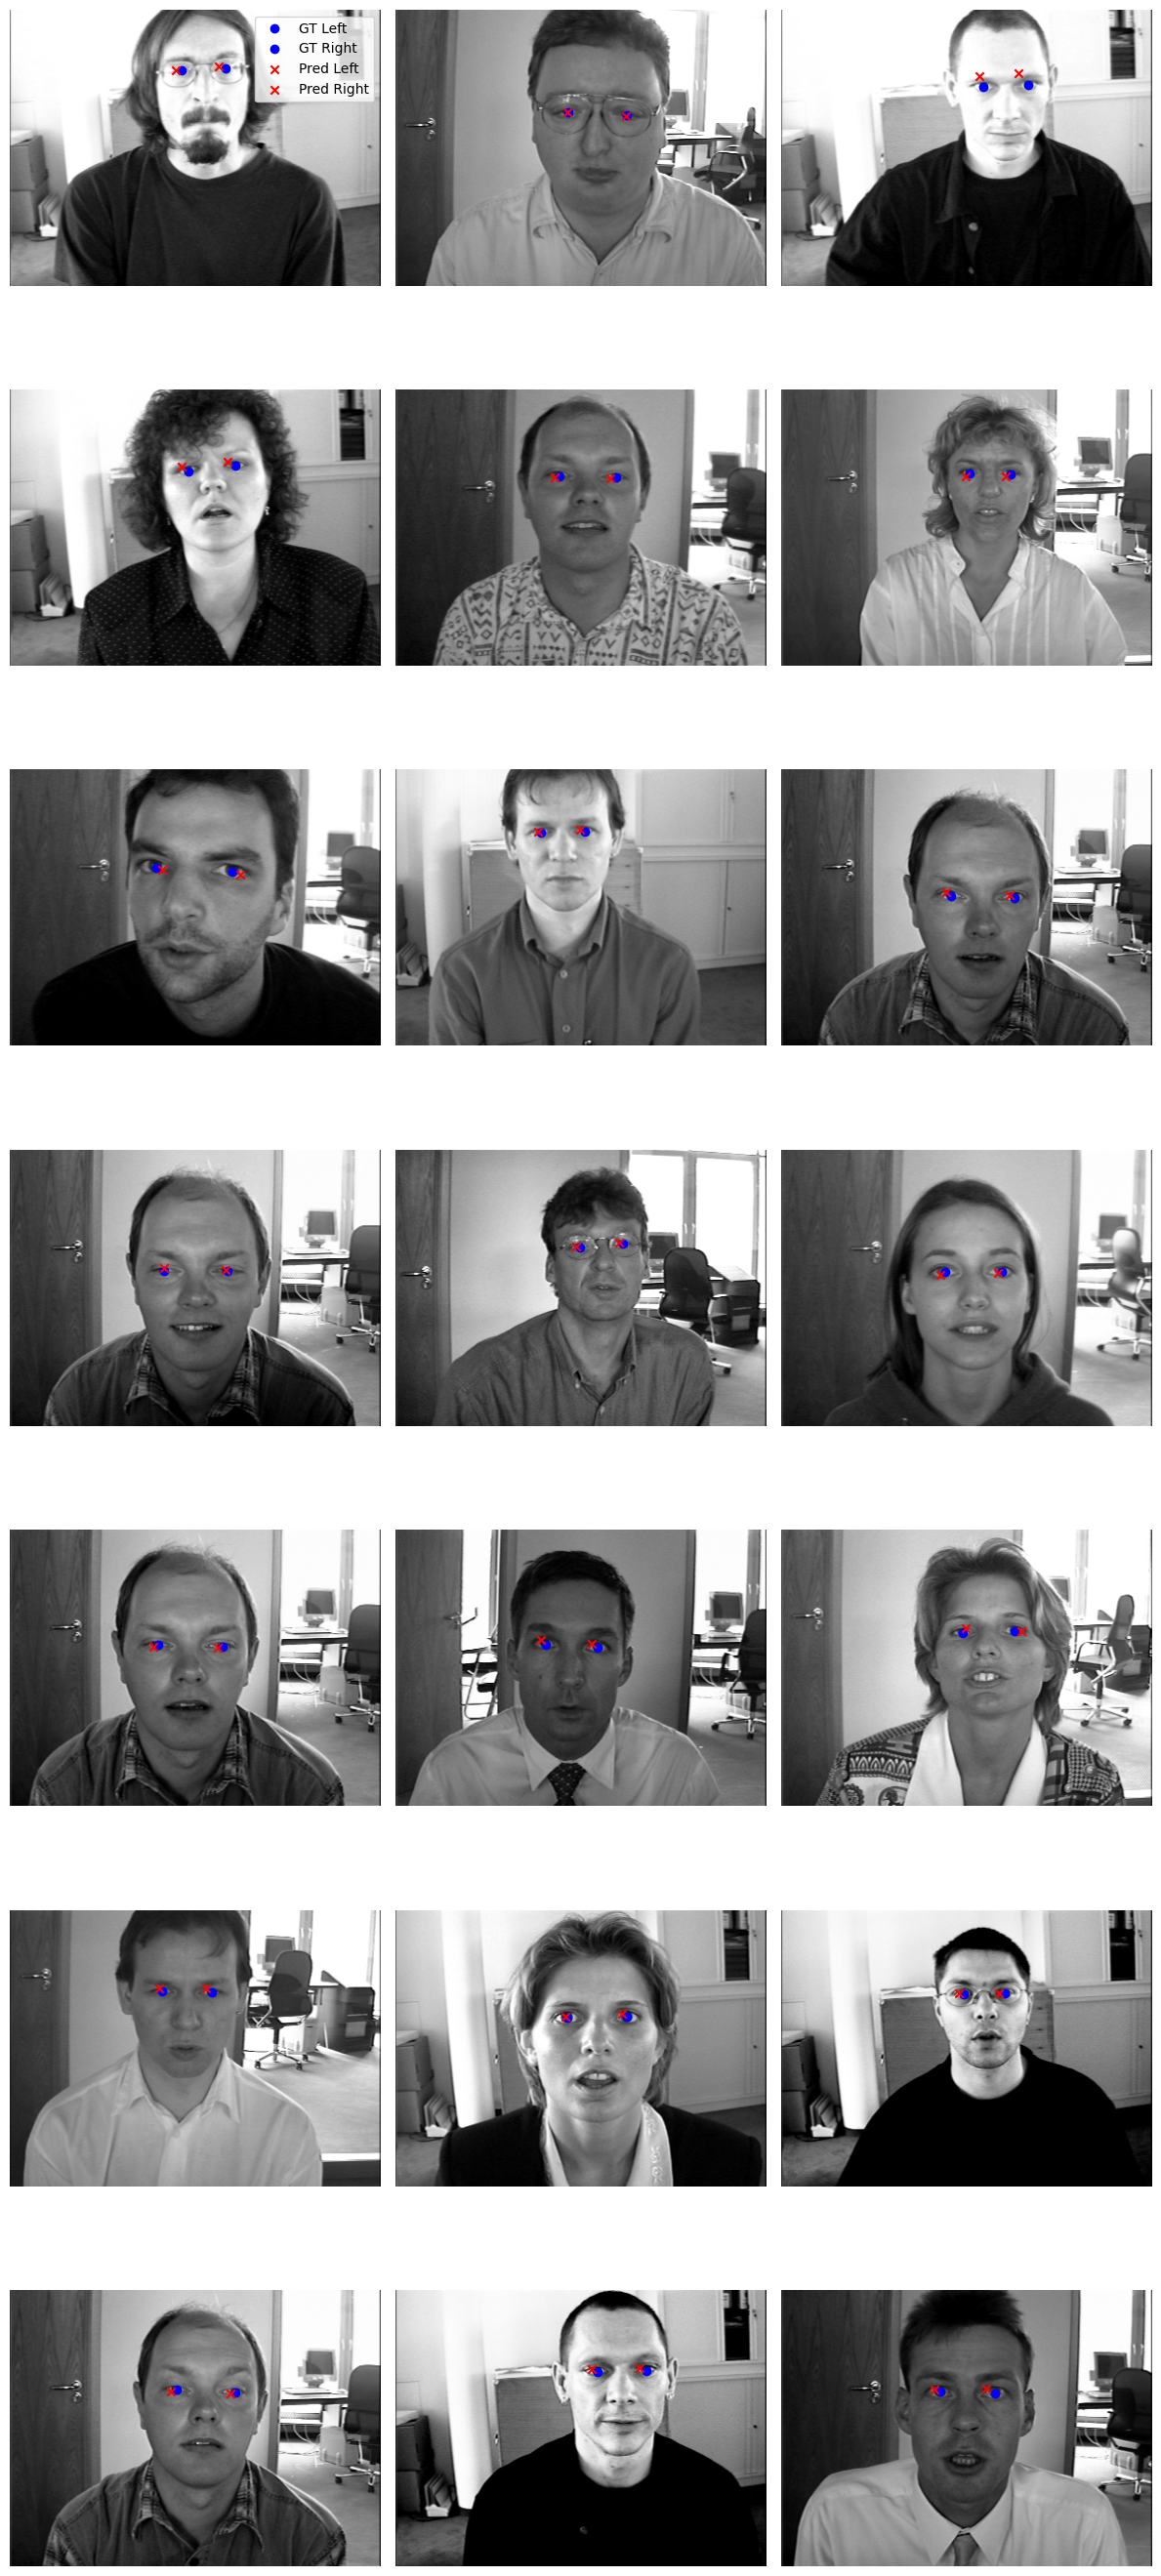

In [ ]:
visualize_predictions(holdout_dataset, predictions, 21, 3)

In [ ]:
!pip uninstall keras tensorflow -y
!pip install keras==2.9.0

Found existing installation: keras 2.12.0
Uninstalling keras-2.12.0:
  Successfully uninstalled keras-2.12.0
Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Successfully uninstalled tensorflow-2.12.0
  Using cached keras-2.9.0-py2.py3-none-any.whl.metadata (1.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.3 MB/s eta 0:00:00


In [ ]:
!pip uninstall tensorflow -y
!pip install tensorflow==2.12.0

  Using cached tensorflow-2.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached keras-2.12.0-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached tensorflow-2.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (586.0 MB)
Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
^C


In [ ]:
!pip install retina-face

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.3 MB/s eta 0:00:00
  Using cached ml_dtypes-0.5.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (21 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 908.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 90.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.3
    Uninstalling tensorboard-2.12.3:
      Successfully uninstalled tensorboard-2.12.3
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstall

In [ ]:
from retinaface import RetinaFace

def compare_eye_coords(input_dir):
    files = sorted([f for f in os.listdir(input_dir) if f.lower().endswith(".pgm")])
    success_count = 0
    fail_count = 0

    def read_eye_file(eye_path):
        try:
            with open(eye_path, 'r') as f:
                lines = f.readlines()
                if len(lines) < 2:
                    return None
                values = lines[1].strip().split()
                lx, ly, rx, ry = map(int, values)
                return (lx, ly), (rx, ry)
        except:
            return None

    print("filename\tGT_L\tGT_R\tPR_L\tPR_R\tL_error\tR_error")

    for filename in files:
        image_path = os.path.join(input_dir, filename)
        eye_path = image_path.replace(".pgm", ".eye")

        gt_coords = read_eye_file(eye_path)
        gt_left, gt_right = gt_coords

        gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

        try:
            faces = RetinaFace.detect_faces(rgb)
            if not faces:
                print(f"❌ 얼굴 인식 실패: {filename}")
                fail_count += 1
                continue

            face = list(faces.values())[0]
            landmarks = face["landmarks"]
            pr_left = landmarks["left_eye"]
            pr_right = landmarks["right_eye"]

            l_error = round(np.linalg.norm(np.array(gt_left) - np.array(pr_left)), 2)
            r_error = round(np.linalg.norm(np.array(gt_right) - np.array(pr_right)), 2)

            print(f"{filename}\t{gt_left}\t{gt_right}\t{pr_left}\t{pr_right}\t{l_error}\t{r_error}")
            success_count += 1

        except Exception as e:
            print(f"❌ 예외 발생: {filename} - {type(e).__name__}: {e}")
            fail_count += 1

    print(f"\n✅ 처리 완료. 총 성공: {success_count}, 실패: {fail_count}")

In [ ]:
compare_eye_coords("/content/drive/MyDrive/comparisons")

filename	GT_L	GT_R	PR_L	PR_R	L_error	R_error
❌ 예외 발생: BioID_0134.pgm - ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```

❌ 예외 발생: BioID_0181.pgm - ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations